In [ ]:
!pip install keras

In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

Using TensorFlow backend.


In [2]:
def build_rand_feat():
    x = []
    y = []
    _min, _max = float('inf'),-float('inf')
    #뉴럴 네트워크에선 보통 결과값을 0~1로 정제하기떄문에
    #min max값을 아는것이 중요하다.
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        x_sample = mfcc(sample, rate,
                       numcep=config.nfeat, nfft=config.nfft).T
        _min = min(np.amin(x_sample), _min)
        _max = max(np.amin(x_sample), _max)
        x.append(x_sample if config.mode == 'conv' else x_sample.T)
        y.append(classes.index(label))
    x, y = np.array(x), np.array(y)
    x = (x- _min) / (_max - _min)
    if config.mode == 'conv':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    elif config.mode == 'time':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
    y = to_categorical(y, num_classes=10)
    
    return x,y

In [3]:
def get_recurrent_model():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True ,input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model
    

In [4]:
def get_conv_model():
    model = Sequential()
    #렐루모델 학습을 1,1씩 한다.
    model.add(Conv2D(16, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(Conv2D(128, (3,3), activation='relu',strides=(1, 1),
                    padding="same", input_shape=input_shape))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0,5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [5]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat = 13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step = int(rate/10)

In [7]:
df = pd.read_csv('dataset.csv')
df.set_index('fname', inplace=True)

In [8]:
df

label
fname             
A.wav       scream
A-2.wav     scream
A-3.wav     scream
A-4.wav     scream
A-5.wav     scream
A-6.wav     scream
A-7.wav     scream
A-8.wav     scream
A-9.wav     scream
A-10.wav    scream
A-11.wav    scream
A-12.wav    scream
B.wav       scream
B-2.wav     scream
B-3.wav     scream
B-4.wav     scream
B-5.wav     scream
B-6.wav     scream
B-7.wav     scream
B-8.wav     scream
B-9.wav     scream
B-10.wav    scream
B-11.wav    scream
B-12.wav    scream
C.wav       scream
C-2.wav     scream
C-3.wav     scream
C-4.wav     scream
C-5.wav     scream
C-6.wav     scream
...            ...
gg-7.wav      talk
gg-8.wav      talk
gg-9.wav      talk
gg-10.wav     talk
gg-11.wav     talk
gg-12.wav     talk
hh.wav        talk
hh-2.wav      talk
hh-3.wav      talk
hh-4.wav      talk
hh-5.wav      talk
hh-6.wav      talk
hh-7.wav      talk
hh-8.wav      talk
hh-9.wav      talk
hh-10.wav     talk
hh-11.wav     talk
hh-12.wav     talk
ii.wav        talk
ii-2.wav      talk
ii-3.wav      talk
ii-4.wav      talk
ii-5.wav      talk
ii-6.wav      talk
ii-7.wav      talk
ii-8.wav      talk
ii-9.wav      talk
ii-10.wav     talk
ii-11.wav     talk
ii-12.wav     talk

[216 rows x 1 columns]

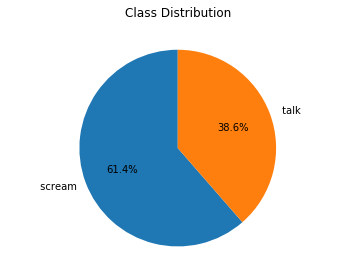

In [9]:
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

#10분의 1로 데이터를 자름
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
#카테고리 하나 랜덤으로 뽑아옴
choices = np.random.choice(class_dist.index, p= prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [10]:
config = Config(mode='conv')

In [11]:
if config.mode =='conv':
    x,y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (x.shape[1], x.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    x,y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (x.shape[1], x.shape[2], 1)
    model = get_recurrent_model()

class_weight = compute_class_weight('balanced',
                                   np.unique(y_flat),
                                   y_flat)

model.fit(x,y, epochs=10, batch_size=32,
         shuffle = True,
         class_weight=class_weight)



100%|█████████████████████████████████████████████████████████████████████████████| 4450/4450 [00:13<00:00, 337.64it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
__________

4450/4450 [==============================] - ETA: 12s - loss: 0.0137 - acc: 1.00 - ETA: 12s - loss: 0.0435 - acc: 0.98 - ETA: 12s - loss: 0.0371 - acc: 0.98 - ETA: 12s - loss: 0.0303 - acc: 0.99 - ETA: 12s - loss: 0.0267 - acc: 0.99 - ETA: 11s - loss: 0.0574 - acc: 0.97 - ETA: 11s - loss: 0.0528 - acc: 0.98 - ETA: 11s - loss: 0.0467 - acc: 0.98 - ETA: 11s - loss: 0.0452 - acc: 0.98 - ETA: 11s - loss: 0.0452 - acc: 0.98 - ETA: 11s - loss: 0.0419 - acc: 0.98 - ETA: 11s - loss: 0.0398 - acc: 0.98 - ETA: 11s - loss: 0.0378 - acc: 0.99 - ETA: 11s - loss: 0.0389 - acc: 0.99 - ETA: 11s - loss: 0.0366 - acc: 0.99 - ETA: 11s - loss: 0.0503 - acc: 0.98 - ETA: 11s - loss: 0.0479 - acc: 0.98 - ETA: 11s - loss: 0.0453 - acc: 0.98 - ETA: 11s - loss: 0.0435 - acc: 0.99 - ETA: 10s - loss: 0.0417 - acc: 0.99 - ETA: 10s - loss: 0.0399 - acc: 0.99 - ETA: 11s - loss: 0.0383 - acc: 0.99 - ETA: 10s - loss: 0.0376 - acc: 0.99 - ETA: 10s - loss: 0.0362 - acc: 0.99 - ETA: 10s - loss: 0.0351 - acc: 0.99 - ETA: 

4450/4450 [==============================] - ETA: 12s - loss: 0.0304 - acc: 1.00 - ETA: 14s - loss: 0.0170 - acc: 1.00 - ETA: 14s - loss: 0.0183 - acc: 1.00 - ETA: 14s - loss: 0.0179 - acc: 1.00 - ETA: 14s - loss: 0.0157 - acc: 1.00 - ETA: 14s - loss: 0.0154 - acc: 1.00 - ETA: 13s - loss: 0.0152 - acc: 1.00 - ETA: 13s - loss: 0.0134 - acc: 1.00 - ETA: 13s - loss: 0.0122 - acc: 1.00 - ETA: 13s - loss: 0.0114 - acc: 1.00 - ETA: 13s - loss: 0.0105 - acc: 1.00 - ETA: 13s - loss: 0.0113 - acc: 1.00 - ETA: 13s - loss: 0.0111 - acc: 1.00 - ETA: 13s - loss: 0.0105 - acc: 1.00 - ETA: 13s - loss: 0.0100 - acc: 1.00 - ETA: 12s - loss: 0.0198 - acc: 0.99 - ETA: 12s - loss: 0.0194 - acc: 0.99 - ETA: 12s - loss: 0.0185 - acc: 0.99 - ETA: 12s - loss: 0.0178 - acc: 0.99 - ETA: 12s - loss: 0.0172 - acc: 0.99 - ETA: 12s - loss: 0.0224 - acc: 0.99 - ETA: 12s - loss: 0.0235 - acc: 0.99 - ETA: 12s - loss: 0.0230 - acc: 0.99 - ETA: 12s - loss: 0.0221 - acc: 0.99 - ETA: 12s - loss: 0.0216 - acc: 0.99 - ETA: 

4450/4450 [==============================] - ETA: 12s - loss: 0.0241 - acc: 1.00 - ETA: 12s - loss: 0.0267 - acc: 0.98 - ETA: 12s - loss: 0.0199 - acc: 0.98 - ETA: 12s - loss: 0.0245 - acc: 0.99 - ETA: 12s - loss: 0.0277 - acc: 0.98 - ETA: 12s - loss: 0.0239 - acc: 0.98 - ETA: 12s - loss: 0.0218 - acc: 0.99 - ETA: 12s - loss: 0.0203 - acc: 0.99 - ETA: 12s - loss: 0.0200 - acc: 0.99 - ETA: 12s - loss: 0.0184 - acc: 0.99 - ETA: 12s - loss: 0.0169 - acc: 0.99 - ETA: 12s - loss: 0.0251 - acc: 0.99 - ETA: 12s - loss: 0.0235 - acc: 0.99 - ETA: 12s - loss: 0.0228 - acc: 0.99 - ETA: 11s - loss: 0.0213 - acc: 0.99 - ETA: 11s - loss: 0.0201 - acc: 0.99 - ETA: 11s - loss: 0.0280 - acc: 0.99 - ETA: 11s - loss: 0.0377 - acc: 0.98 - ETA: 11s - loss: 0.0359 - acc: 0.99 - ETA: 11s - loss: 0.0409 - acc: 0.98 - ETA: 11s - loss: 0.0395 - acc: 0.98 - ETA: 11s - loss: 0.0400 - acc: 0.98 - ETA: 11s - loss: 0.0388 - acc: 0.98 - ETA: 11s - loss: 0.0374 - acc: 0.98 - ETA: 11s - loss: 0.0368 - acc: 0.98 - ETA: 

4450/4450 [==============================] - ETA: 10s - loss: 6.8463e-05 - acc: 1.00 - ETA: 11s - loss: 6.0104e-05 - acc: 1.00 - ETA: 11s - loss: 1.0911e-04 - acc: 1.00 - ETA: 12s - loss: 1.4807e-04 - acc: 1.00 - ETA: 13s - loss: 0.0098 - acc: 0.9938   - ETA: 12s - loss: 0.0081 - acc: 0.99 - ETA: 12s - loss: 0.0071 - acc: 0.99 - ETA: 12s - loss: 0.0072 - acc: 0.99 - ETA: 12s - loss: 0.0176 - acc: 0.99 - ETA: 11s - loss: 0.0176 - acc: 0.99 - ETA: 11s - loss: 0.0166 - acc: 0.99 - ETA: 11s - loss: 0.0154 - acc: 0.99 - ETA: 11s - loss: 0.0143 - acc: 0.99 - ETA: 11s - loss: 0.0134 - acc: 0.99 - ETA: 11s - loss: 0.0149 - acc: 0.99 - ETA: 11s - loss: 0.0141 - acc: 0.99 - ETA: 11s - loss: 0.0132 - acc: 0.99 - ETA: 11s - loss: 0.0126 - acc: 0.99 - ETA: 10s - loss: 0.0131 - acc: 0.99 - ETA: 10s - loss: 0.0127 - acc: 0.99 - ETA: 10s - loss: 0.0121 - acc: 0.99 - ETA: 10s - loss: 0.0117 - acc: 0.99 - ETA: 10s - loss: 0.0113 - acc: 0.99 - ETA: 10s - loss: 0.0132 - acc: 0.99 - ETA: 10s - loss: 0.0127

4450/4450 [==============================] - ETA: 11s - loss: 0.0159 - acc: 1.00 - ETA: 11s - loss: 0.0111 - acc: 1.00 - ETA: 11s - loss: 0.0084 - acc: 1.00 - ETA: 11s - loss: 0.0081 - acc: 1.00 - ETA: 11s - loss: 0.0087 - acc: 1.00 - ETA: 11s - loss: 0.0142 - acc: 0.99 - ETA: 11s - loss: 0.0123 - acc: 0.99 - ETA: 11s - loss: 0.0108 - acc: 0.99 - ETA: 11s - loss: 0.0107 - acc: 0.99 - ETA: 11s - loss: 0.0099 - acc: 0.99 - ETA: 11s - loss: 0.0092 - acc: 0.99 - ETA: 11s - loss: 0.0086 - acc: 0.99 - ETA: 11s - loss: 0.0115 - acc: 0.99 - ETA: 11s - loss: 0.0208 - acc: 0.99 - ETA: 11s - loss: 0.0199 - acc: 0.99 - ETA: 11s - loss: 0.0190 - acc: 0.99 - ETA: 11s - loss: 0.0184 - acc: 0.99 - ETA: 11s - loss: 0.0178 - acc: 0.99 - ETA: 11s - loss: 0.0169 - acc: 0.99 - ETA: 11s - loss: 0.0161 - acc: 0.99 - ETA: 11s - loss: 0.0154 - acc: 0.99 - ETA: 11s - loss: 0.0147 - acc: 0.99 - ETA: 11s - loss: 0.0141 - acc: 0.99 - ETA: 10s - loss: 0.0136 - acc: 0.99 - ETA: 10s - loss: 0.0131 - acc: 0.99 - ETA: 

4450/4450 [==============================] - ETA: 11s - loss: 0.0128 - acc: 1.00 - ETA: 12s - loss: 0.0069 - acc: 1.00 - ETA: 12s - loss: 0.0111 - acc: 1.00 - ETA: 12s - loss: 0.0208 - acc: 0.99 - ETA: 12s - loss: 0.0172 - acc: 0.99 - ETA: 11s - loss: 0.0144 - acc: 0.99 - ETA: 11s - loss: 0.0124 - acc: 0.99 - ETA: 11s - loss: 0.0109 - acc: 0.99 - ETA: 12s - loss: 0.0098 - acc: 0.99 - ETA: 11s - loss: 0.0089 - acc: 0.99 - ETA: 11s - loss: 0.0082 - acc: 0.99 - ETA: 11s - loss: 0.0081 - acc: 0.99 - ETA: 11s - loss: 0.0075 - acc: 0.99 - ETA: 11s - loss: 0.0070 - acc: 0.99 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 11s - loss: 0.0099 - acc: 0.99 - ETA: 11s - loss: 0.0094 - acc: 0.99 - ETA: 10s - loss: 0.0097 - acc: 0.99 - ETA: 10s - loss: 0.0109 - acc: 0.99 - ETA: 10s - loss: 0.0103 - acc: 0.99 - ETA: 10s - loss: 0.0099 - acc: 0.99 - ETA: 10s - loss: 0.0095 - acc: 0.99 - ETA: 10s - loss: 0.0129 - acc: 0.99 - ETA: 10s - loss: 0.0124 - acc: 0.99 - ETA: 10s - loss: 0.0122 - acc: 0.99 - ETA: 

4450/4450 [==============================] - ETA: 11s - loss: 0.0021 - acc: 1.00 - ETA: 12s - loss: 0.0112 - acc: 1.00 - ETA: 11s - loss: 0.0084 - acc: 1.00 - ETA: 12s - loss: 0.0066 - acc: 1.00 - ETA: 12s - loss: 0.0055 - acc: 1.00 - ETA: 12s - loss: 0.0048 - acc: 1.00 - ETA: 12s - loss: 0.0074 - acc: 0.99 - ETA: 12s - loss: 0.0065 - acc: 0.99 - ETA: 12s - loss: 0.0067 - acc: 0.99 - ETA: 11s - loss: 0.0107 - acc: 0.99 - ETA: 11s - loss: 0.0211 - acc: 0.99 - ETA: 11s - loss: 0.0195 - acc: 0.99 - ETA: 11s - loss: 0.0181 - acc: 0.99 - ETA: 11s - loss: 0.0172 - acc: 0.99 - ETA: 11s - loss: 0.0170 - acc: 0.99 - ETA: 11s - loss: 0.0162 - acc: 0.99 - ETA: 11s - loss: 0.0163 - acc: 0.99 - ETA: 11s - loss: 0.0157 - acc: 0.99 - ETA: 11s - loss: 0.0150 - acc: 0.99 - ETA: 11s - loss: 0.0143 - acc: 0.99 - ETA: 11s - loss: 0.0143 - acc: 0.99 - ETA: 11s - loss: 0.0138 - acc: 0.99 - ETA: 10s - loss: 0.0134 - acc: 0.99 - ETA: 10s - loss: 0.0131 - acc: 0.99 - ETA: 10s - loss: 0.0146 - acc: 0.99 - ETA: 

4450/4450 [==============================] - ETA: 10s - loss: 1.0119e-04 - acc: 1.00 - ETA: 11s - loss: 0.0038 - acc: 1.0000   - ETA: 11s - loss: 0.0026 - acc: 1.00 - ETA: 11s - loss: 0.0039 - acc: 1.00 - ETA: 11s - loss: 0.0033 - acc: 1.00 - ETA: 12s - loss: 0.0028 - acc: 1.00 - ETA: 11s - loss: 0.0028 - acc: 1.00 - ETA: 11s - loss: 0.0024 - acc: 1.00 - ETA: 11s - loss: 0.0022 - acc: 1.00 - ETA: 12s - loss: 0.0024 - acc: 1.00 - ETA: 12s - loss: 0.0022 - acc: 1.00 - ETA: 11s - loss: 0.0020 - acc: 1.00 - ETA: 11s - loss: 0.0069 - acc: 0.99 - ETA: 12s - loss: 0.0065 - acc: 0.99 - ETA: 11s - loss: 0.0060 - acc: 0.99 - ETA: 11s - loss: 0.0057 - acc: 0.99 - ETA: 11s - loss: 0.0053 - acc: 0.99 - ETA: 11s - loss: 0.0052 - acc: 0.99 - ETA: 11s - loss: 0.0057 - acc: 0.99 - ETA: 11s - loss: 0.0055 - acc: 0.99 - ETA: 11s - loss: 0.0052 - acc: 0.99 - ETA: 11s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99

4450/4450 [==============================] - ETA: 11s - loss: 0.0331 - acc: 0.96 - ETA: 12s - loss: 0.0680 - acc: 0.96 - ETA: 12s - loss: 0.0461 - acc: 0.97 - ETA: 12s - loss: 0.0440 - acc: 0.97 - ETA: 12s - loss: 0.0370 - acc: 0.98 - ETA: 12s - loss: 0.0308 - acc: 0.98 - ETA: 12s - loss: 0.0266 - acc: 0.98 - ETA: 11s - loss: 0.0242 - acc: 0.98 - ETA: 11s - loss: 0.0323 - acc: 0.98 - ETA: 11s - loss: 0.0354 - acc: 0.98 - ETA: 11s - loss: 0.0322 - acc: 0.98 - ETA: 11s - loss: 0.0322 - acc: 0.98 - ETA: 11s - loss: 0.0298 - acc: 0.98 - ETA: 11s - loss: 0.0280 - acc: 0.98 - ETA: 11s - loss: 0.0262 - acc: 0.98 - ETA: 11s - loss: 0.0246 - acc: 0.98 - ETA: 10s - loss: 0.0232 - acc: 0.98 - ETA: 10s - loss: 0.0220 - acc: 0.98 - ETA: 10s - loss: 0.0208 - acc: 0.98 - ETA: 10s - loss: 0.0269 - acc: 0.98 - ETA: 10s - loss: 0.0497 - acc: 0.98 - ETA: 10s - loss: 0.0476 - acc: 0.98 - ETA: 10s - loss: 0.0456 - acc: 0.98 - ETA: 10s - loss: 0.0486 - acc: 0.98 - ETA: 10s - loss: 0.0467 - acc: 0.98 - ETA: 

In [13]:
from keras.models import load_model
#model = load_model('ver1.0.h5')

In [14]:
model.save('ver1.0.h5')

In [7]:
rate, signal = wavfile.read('clean/0c67f402.wav')